In [84]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from preprocessing import preprocess
from gating import *
from visualization import *
from cluster import *

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
data_path = '../data/'
labels_path = '../labels/'
cluster_model = 'kmeans'
labels_cluster_path = labels_path + cluster_model + '/'

if not os.path.exists(labels_cluster_path):
    os.makedirs(labels_cluster_path)

course = 'dsp_001'
path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
hard_fail = path + 'feature_labels.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Feature gating with annealing loss


In [537]:
for percentile in [0.2, 0.4, 0.6, 0.8]:
    x_train, x_test, x_val, y_train, y_test, y_val, feature_names, patterns = preprocess(course, path, percentile, feature_types, metadata, hard_fail)
    
    # Concat features & labels for later analysis
    X = np.concatenate([x_train, x_val, x_test], axis=0)
    Y = np.concatenate([y_train, y_val, y_test], axis=0)
    P = np.concatenate(patterns, axis=0)
    
    # Set up parameters and model to train
    meta = {'gumbel_temp': 1, 'gumbel_noise': 1e-8}
    params = {
        'epochs': 20,
        'batch_size': 64,
        'optimizer': tf.keras.optimizers.Adam()
    }
    model = MaskingModel(n_groups=x_train.shape[-1])
    
    # Train model
    print("Training model for percentile {0} of data\n".format(percentile))
    scores = custom_train(model, params, meta, x_train, y_train, x_val, y_val)
    
    # Save model
    model.save_weights(MODEL_PATH + 'annealing_fg_hard_fail_perc_'+str(percentile))

Training model for percentile 0.2 of data

Epoch 0: 	 0.6761 loss 	&	 0.4941 ROC AUC
Validation 0: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 1: 	 0.6202 loss 	&	 0.4935 ROC AUC
Validation 1: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 2: 	 0.5920 loss 	&	 0.4994 ROC AUC
Validation 2: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 3: 	 0.5882 loss 	&	 0.5277 ROC AUC
Validation 3: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 4: 	 0.5863 loss 	&	 0.5887 ROC AUC
Validation 4: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 5: 	 0.5853 loss 	&	 0.6127 ROC AUC
Validation 5: 	 11.5031 loss 	&	 0.5000 ROC AUC
Epoch 6: 	 0.5835 loss 	&	 0.6358 ROC AUC
Validation 6: 	 0.7625 loss 	&	 0.6893 ROC AUC
Epoch 7: 	 0.5811 loss 	&	 0.6480 ROC AUC
Validation 7: 	 0.7711 loss 	&	 0.6990 ROC AUC
Epoch 8: 	 0.5789 loss 	&	 0.6557 ROC AUC
Validation 8: 	 0.8055 loss 	&	 0.6932 ROC AUC
Epoch 9: 	 0.5766 loss 	&	 0.6666 ROC AUC
Validation 9: 	 0.8504 loss 	&	 0.6927 ROC AUC
Epoch 10: 	 0.5762 loss 	&	 0.6594 ROC AUC
Validation 10: 	 0

### Spectral Clustering - euclidean distance

In [76]:
labels_cluster_path = labels_path + 'spectral_clustering/'
for percentile in [0.2, 0.4, 0.6, 0.8]:
    filename = 'annealing_fg_hard_fail_perc_'+str(percentile)
    feature_names, masks, X_masked, _, Y, _ = get_truncated_features(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, hard_fail)
    D = compute_distance_matrix(X_masked, 'euclidean')
    S = np.exp(-0.5 * D ** 2)
    score, n, labels = compute_number_clusters(S, spectral_clustering, silhouette_score, distance_matrix=D, verbose=False)
    np.savetxt(labels_cluster_path+'masked_hard_fail_perc_'+str(percentile)+'.txt', labels, fmt='%d')

In [79]:
create_sankey_diagram(labels_cluster_path, 'masked_hard_fail_perc_', [0.2, 0.4, 0.6, 0.8], Y)

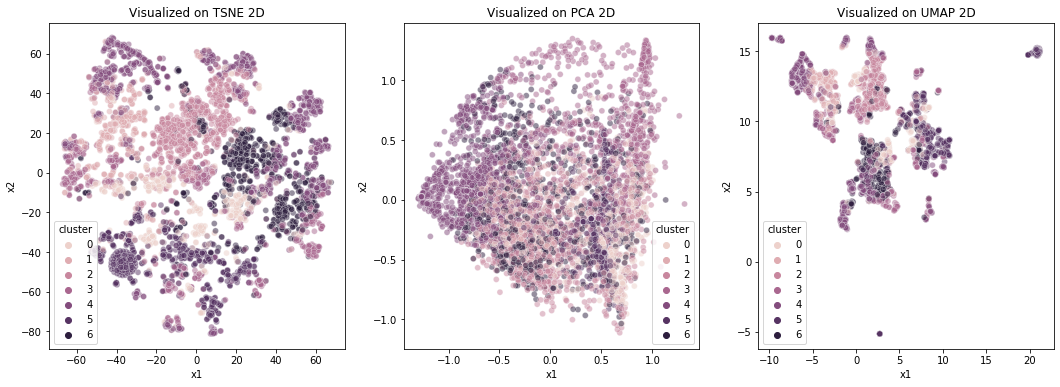

In [83]:
# Get X_masked and cluster labels for percentile 0.6
labels_cluster_path = labels_path + 'spectral_clustering/'
filename = 'annealing_fg_hard_fail_perc_0.6'
feature_names, masks, X_masked, _, Y, _ = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, hard_fail)
labels = np.loadtxt(labels_cluster_path+'masked_hard_fail_perc_0.6.txt', dtype=int)

plot_tsne_and_pca(X_masked, labels)

### KMeans 

In [80]:
labels_cluster_path = labels_path + 'kmeans/'
for percentile in [0.2, 0.4, 0.6, 0.8]:
    filename = 'annealing_fg_hard_fail_perc_'+str(percentile)
    feature_names, masks, X_masked, _, Y, _ = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, hard_fail)
    score, n, labels = compute_number_clusters(X_masked, kmeans_, silhouette_score, verbose=False)
    np.savetxt(labels_cluster_path+'masked_hard_fail_perc_'+str(percentile)+'.txt', labels, fmt='%d')

In [66]:
create_sankey_diagram(labels_cluster_path, 'masked_hard_fail_perc_', [0.2, 0.4, 0.6, 0.8], Y)

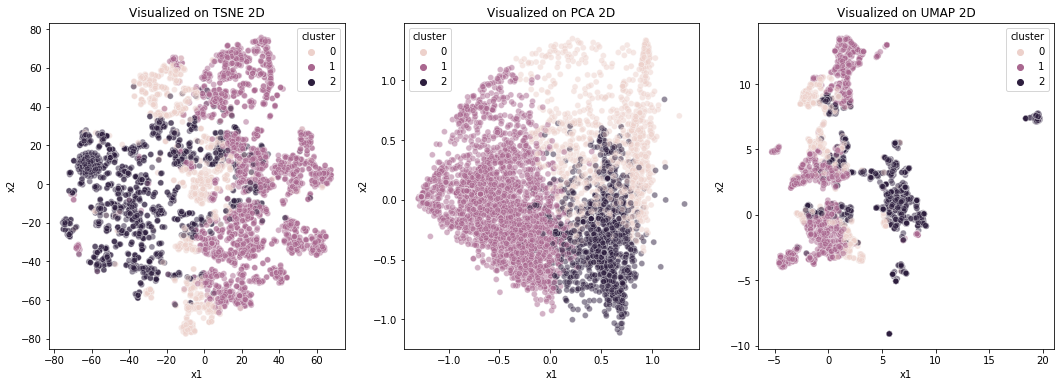

In [81]:
# Get X_masked and cluster labels for percentile 0.6
filename = 'annealing_fg_hard_fail_perc_0.6'
feature_names, masks, X_masked, _, Y, _ = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, hard_fail)
labels = np.loadtxt(labels_cluster_path+'masked_hard_fail_perc_0.6.txt', dtype=int)

plot_tsne_and_pca(X_masked, labels)

### Grouping into concepts

In [90]:
# Get X_masked and cluster labels for percentile 0.6
labels_cluster_path = labels_path + 'kmeans/'
filename = 'annealing_fg_hard_fail_perc_0.6'
feature_names, masks, X_masked, _, Y, P = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, hard_fail)
labels = np.loadtxt(labels_cluster_path+'masked_hard_fail_perc_0.6.txt', dtype=int)


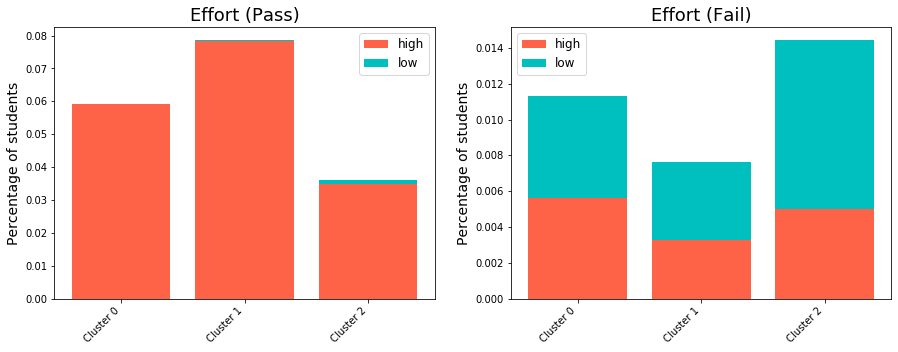

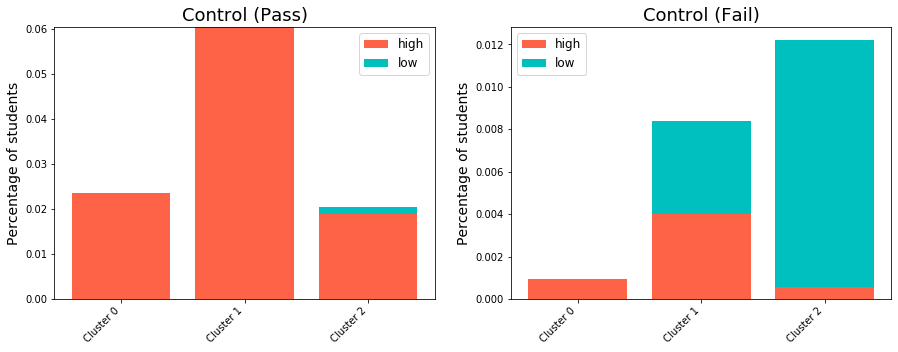

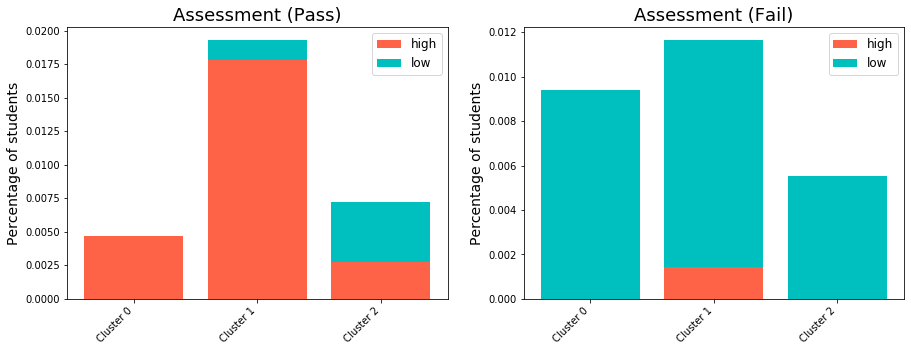

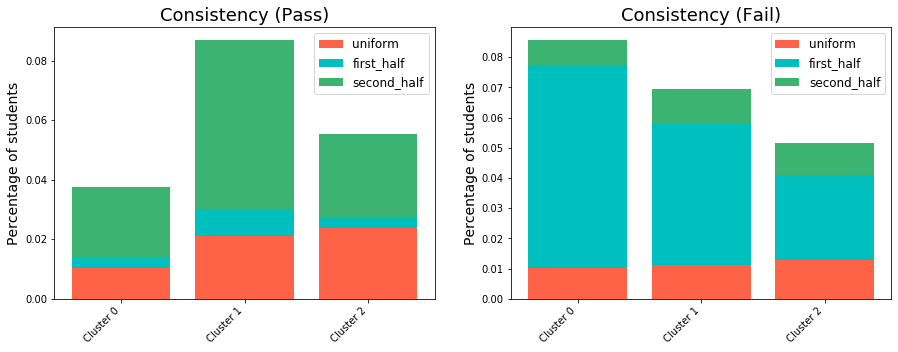

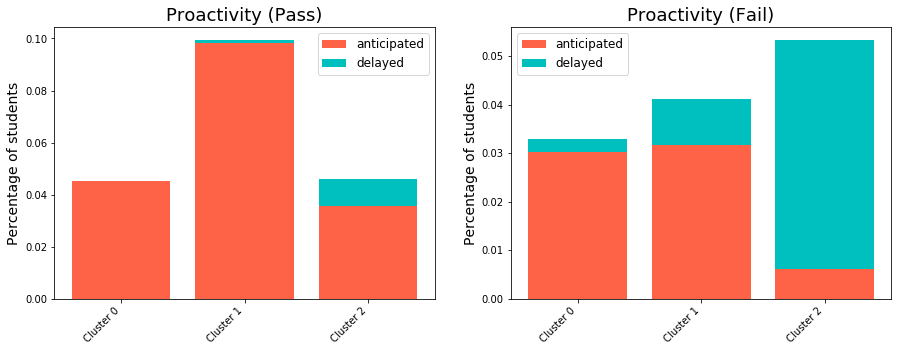

In [91]:
# Effort, control, assessment
for pat_id, pat in [(0, 'Effort'), (3, 'Control'), (4, 'Assessment')]:
    plot_concepts(Y, P, pat, pat_id, ['high', 'low'], labels)
# Consistency  
plot_concepts(Y, P, 'Consistency', 1, ['uniform', 'first_half', 'second_half'], labels)
# Proactivity
plot_concepts(Y, P, 'Proactivity', 2, ['anticipated', 'delayed'], labels)

In [92]:
def distributions_pass_fail(labels):
    fail_pass_total = []
    fail_pass = []
    for c in range(np.max(np.unique(labels))+1):
        cluster = np.where(labels == c)[0]
        y_cluster = tf.gather(Y, list(cluster)).numpy()

        fail_pass_total.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(Y), (y_cluster == 1).sum()/len(Y)))
        fail_pass.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(y_cluster), (y_cluster == 1).sum()/len(y_cluster)))
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].bar([i[0] for i in fail_pass_total], [i[1] for i in fail_pass_total], label="Pass", color='tomato')
    ax[0].bar([i[0] for i in fail_pass_total], [i[2] for i in fail_pass_total], bottom=[i[1] for i in fail_pass_total], label="Fail", color='c')
    ax[0].set_title('Distribution of Pass-Fail')
    ax[0].set_ylabel('Percentage of total students')
    ax[0].set_xticklabels([i[0] for i in fail_pass_total], rotation=45, ha='right')
    ax[0].legend()
    
    ax[1].bar([i[0] for i in fail_pass], [i[1] for i in fail_pass], label="Pass", color='tomato')
    ax[1].bar([i[0] for i in fail_pass], [i[2] for i in fail_pass], bottom=[i[1] for i in fail_pass], label="Fail", color='c')
    ax[1].set_title('Distribution of Pass-Fail')
    ax[1].set_ylabel('Percentage of students per cluster')
    ax[1].set_xticklabels([i[0] for i in fail_pass], rotation=45, ha='right')
    ax[1].legend()
    plt.show()


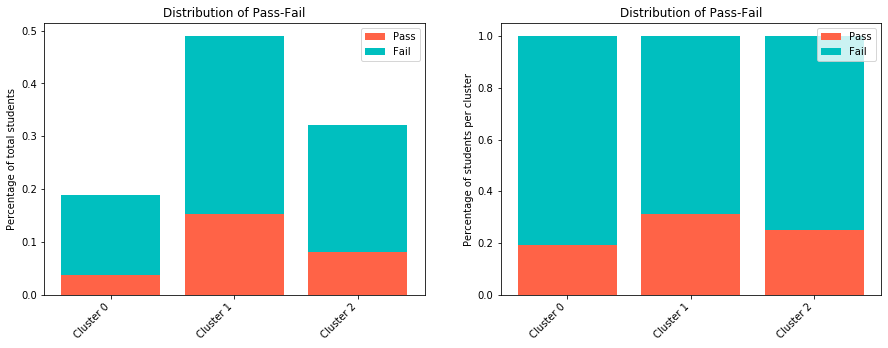

In [93]:
distributions_pass_fail(labels)

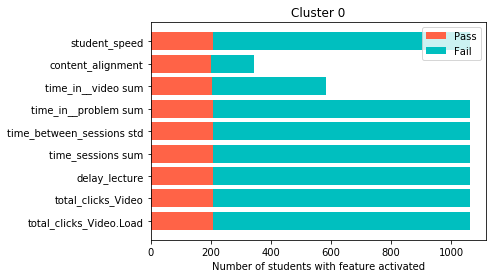

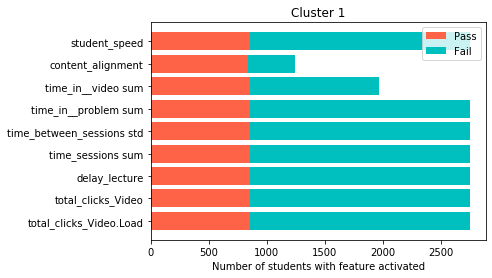

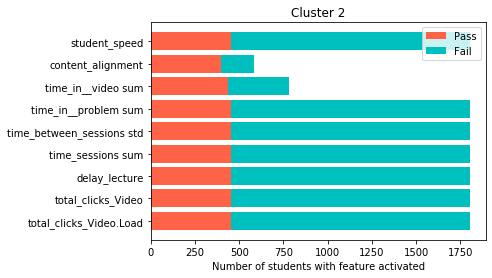

,Cluster,# instances,Avg Features
0,0,1062,7.873823
1,1,2747,8.170367
2,2,1802,7.758047


In [94]:
def number_students_per_feature(labels):
    df = pd.DataFrame()
    clusters_length = []
    avg_feat_per_cluster = []
    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        clusters_length.append(len(cluster))
        avg_feat = np.mean(tf.reduce_sum(tf.gather(masks, list(cluster)), axis=1))
        avg_feat_per_cluster.append(avg_feat)

        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

        f_students = []
        for i in tf.where(f_activated)[:, 0]:
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster)))

            f_students.append((feature_names[i], (Y[a] == 0).sum(), (Y[a] == 1).sum()))
#         f_students = sorted(f_students,key=itemgetter(1))

        plt.barh([i[0] for i in f_students], [i[1] for i in f_students], label="Pass", color='tomato')
        plt.barh([i[0] for i in f_students], [i[2] for i in f_students], left=[i[1] for i in f_students], label="Fail", color='c')
        plt.title('Cluster '+str(c))
        plt.xlabel('Number of students with feature activated')
        plt.legend()
        plt.show()

    df['Cluster'] = [i for i in range(np.max(labels)+1)]
    df['# instances'] = clusters_length
    df['Avg Features'] = avg_feat_per_cluster
    return df
df = number_students_per_feature(labels)
df

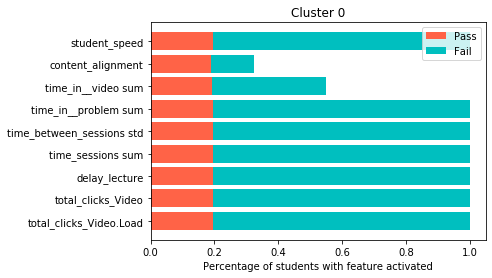

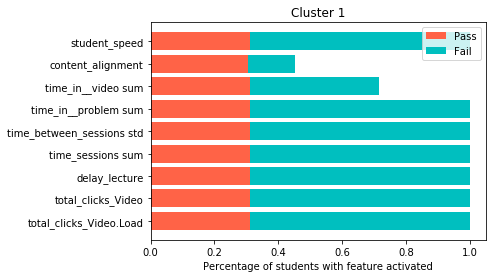

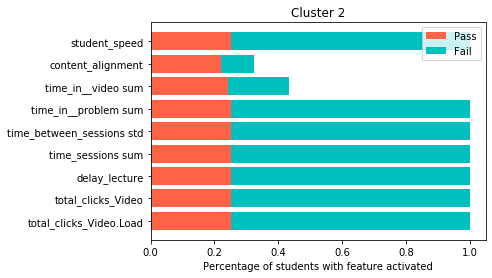

In [95]:
def percentage_students_per_feature(labels):
    clusters_length = []
    avg_feat_per_cluster = []
    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

        f_students = []
        for i in tf.where(f_activated)[:, 0]:
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster)))

            f_students.append((feature_names[i], [(Y[a] == 0).sum()/len(cluster), (Y[a] == 1).sum()/len(cluster)]))

    #     f_students = sorted(f_students, key=lambda x: sum(x[1]))

        plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass", color='tomato')
        plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail", color='c')
        plt.title('Cluster '+str(c))
        plt.xlabel('Percentage of students with feature activated')
        plt.legend()
        plt.show()

percentage_students_per_feature(labels)


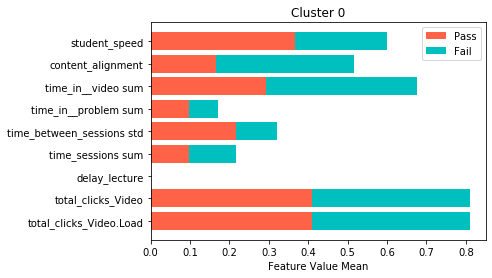

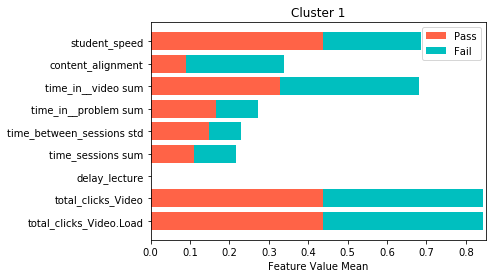

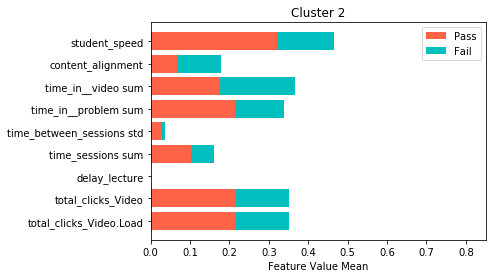

In [99]:
def feature_value(labels):
    clusters_length = []
    avg_feat_per_cluster = []
    for c in range(np.max(labels)+1):

        cluster = np.where(labels == c)[0]
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

        f_students = []
        for i in tf.where(f_activated)[:, 0]:
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster))) 
            
            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
            
            if len(target_0) > 0 and len(target_1) > 0:
                f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i]), 
                                   tf.reduce_mean(X[target_1, :, i])]))
            elif len(target_0) == 0:
                f_students.append((feature_names[i], [0, 
                                   tf.reduce_mean(X[target_1, :, i])]))
            else:
                f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i]), 0]))

    #     f_students = sorted(f_students, key=lambda x: sum(x[1]))

        plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass", color='tomato')
        plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail", color='c')
        plt.title('Cluster '+str(c))
        plt.xlabel('Feature Value Mean')
        plt.legend()
        plt.xlim(0, 0.85)
        plt.show()

feature_value(labels)

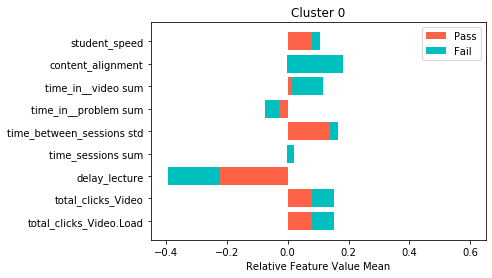

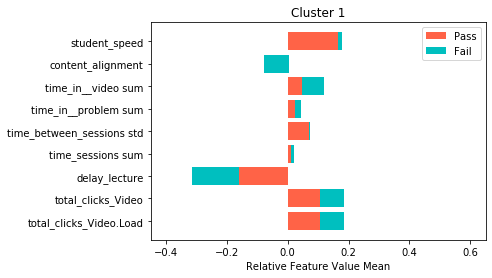

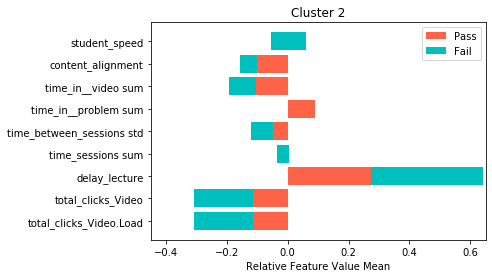

In [104]:
def relative_feature_value(labels):
    df = pd.DataFrame()
    clusters_length = []
    avg_feat_per_cluster = []

    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

        f_students = []
        for i in tf.where(f_activated)[:, 0]:
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster))) 

            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
            
            if len(target_0) > 0 and len(target_1) > 0:
                f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i])-tf.reduce_mean(X[:, :, i]), 
                                   tf.reduce_mean(X[target_1, :, i])-tf.reduce_mean(X[:, :, i])]))
            elif len(target_0) == 0:
                f_students.append((feature_names[i], [0, 
                                   tf.reduce_mean(X[target_1, :, i])-tf.reduce_mean(X[:, :, i])]))
            else:
                f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i])-tf.reduce_mean(X[:, :, i]), 
                               0]))
            
#         f_students = sorted(f_students, key=lambda x: sum(x[1]))


        plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass", color='tomato')
        plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail", color='c')
        plt.title('Cluster '+str(c))
        plt.xlabel('Relative Feature Value Mean')
        plt.legend()
        plt.xlim(-0.45, 0.65)
        plt.show()

    f_mean = []
    f_names = []
    f_max = []
    f_min = []
    f_meadian = []
    for i in tf.where(f_activated)[:, 0]:
        f_mean.append(tf.reduce_mean(X[:, :, i]).numpy())
        f_max.append(tf.reduce_max(X[:, :, i]).numpy())
        f_names.append(feature_names[i])

    df['Feature'] = f_names
    df['Avg Value'] = f_mean
    df['Max Value'] = f_max
    return df

df = relative_feature_value(labels)